# Simulation of BBOB F01

Approach:
- SVM with RBF-Kernel
- 1000 random samples

In [1]:
import sys
import pickle

import numpy as np
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sys.path.append('..')
import model
from utils.utils import create_problem, plot_collage, test_function, calculate_eval_metrics
from utils.optimizer import plot_optimization, plot_optimization_paths, perform_optimization
from gt_sampling import get_sample

sys.path.append("../misc")
import bbob_deferential as bobby


## Create Groundtruth

In [2]:
n_dim = 2
samples = 1000
seed = 42

problem_f01 = create_problem(1, n_dim, seed)

## Sample from Groundtruth

In [3]:
sample_f01 = get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random')

c:\Users\schla\git\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [4]:
X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()
y_input = sample_f01[1].float()  

# input with gradients
X_input_grad1 = torch.tensor(np.concatenate((X_input, sample_f01[2]), axis=1), dtype=torch.float32).clone().detach()

C:\Users\schla\AppData\Local\Temp\ipykernel_27880\3495846831.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()


## Models for Simulation

### Classic SVM

In [5]:
svm_p1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [6]:
svm_p1.fit(X_input, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

Export model:

In [7]:
FOLDER = '../models'
svm1 = pickle.loads(open(f'{FOLDER}/SVM_grad.pkl', 'rb').read())

### SVM with gradients 

In [8]:
svm_grad = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [9]:
# train model with gradients
svm_grad.fit(X_input_grad1, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

In [10]:
pickle.dump(svm_grad, open(f'{FOLDER}/SVM-P01-Grads.pkl', 'wb'))

(estimated by nearest neighbor)

In [11]:
# wrap svm and estimate gradients with nearest neighbor
def svm_grad_1nn(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='nearest_neighbor')

(estimated by GPM)

In [12]:
gradient_estimator = MultiOutputRegressor(GaussianProcessRegressor())
gradient_estimator.fit(X_input, X_input_grad1[:, 2:4])

def svm_grad_gpm(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='estimator', gradient_estimator=gradient_estimator)

## Neural Networks

In [13]:
input_dim = 2
hidden_dim = 8
hidden_layers = 16
output_dim = 1
learning_rate = 0.01
num_epochs = 2000
bs = 256

### Classic Neural Network

In [14]:
nn_classic = model.NN(input_dim, hidden_dim, hidden_layers)
sd = torch.load("../models/f01_mse_nn_model.pt")
nn_classic.load_state_dict(sd);

### Taylor-Zehle-Loss Neural Network

In [15]:
nn_taylor = model.NN1(2, 16, 8)
sd = torch.load("../models/f01_taylor_nn_model02.pt")
nn_taylor.load_state_dict(sd);

### Multioutput Neural Network

see multioutput_nn_experiment --> no sufficient results

## Evaluation

### Graphical Evaluation

In [16]:
x1 = x2 = np.linspace(-5.0, 5.0, 100)
X1, X2 = np.meshgrid(x1, x2)

mesh_samples = np.c_[X1.ravel(), X2.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)


In [17]:
mesh_results_svm_p1 = svm_p1.predict(mesh_samples_tensor).reshape(X1.shape)

c:\ProgramData\Anaconda3\envs\python-3-10-env\MachineLearningProject\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


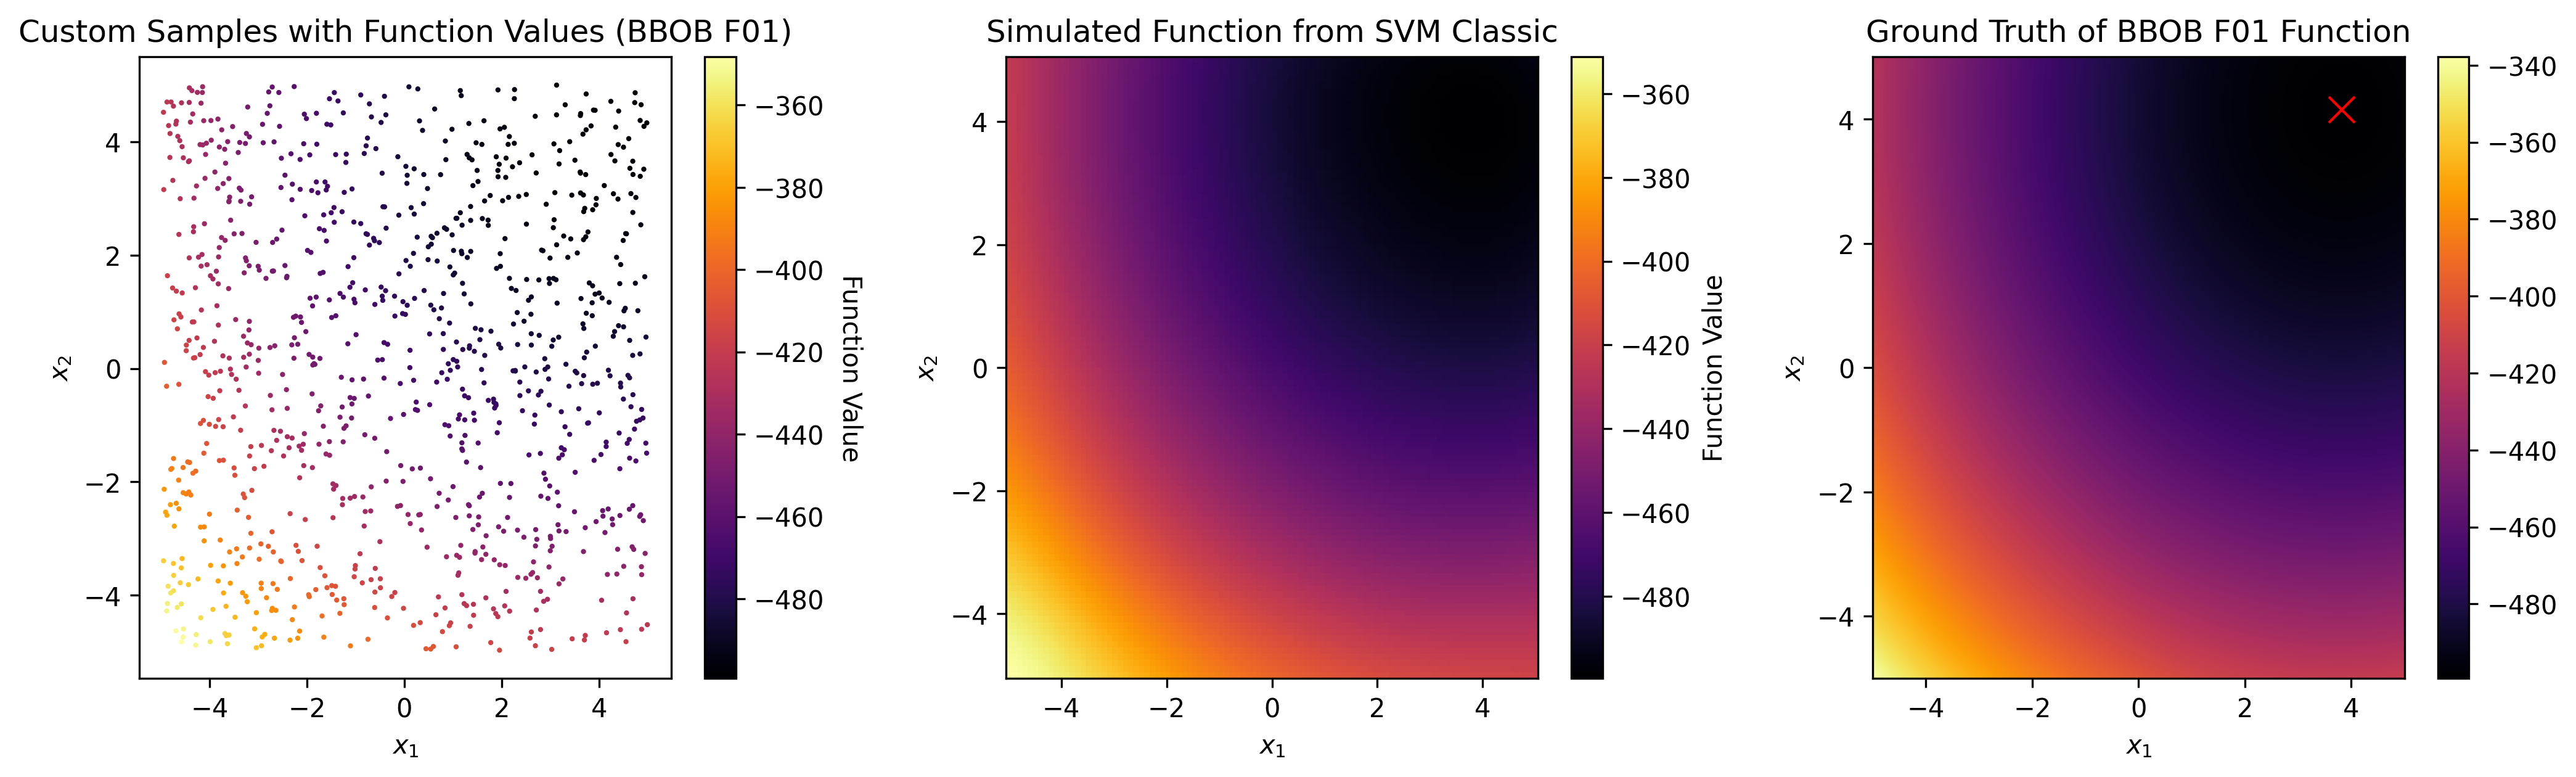

In [18]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "SVM Classic", X1, X2, mesh_results_svm_p1)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

--> on first glance: Classic SVM with RBF-Kernel can simulate the first BBOB function quite well

In [19]:
mesh_results_svm_grad_1nn = svm_grad_1nn(mesh_samples_tensor).reshape(X1.shape)

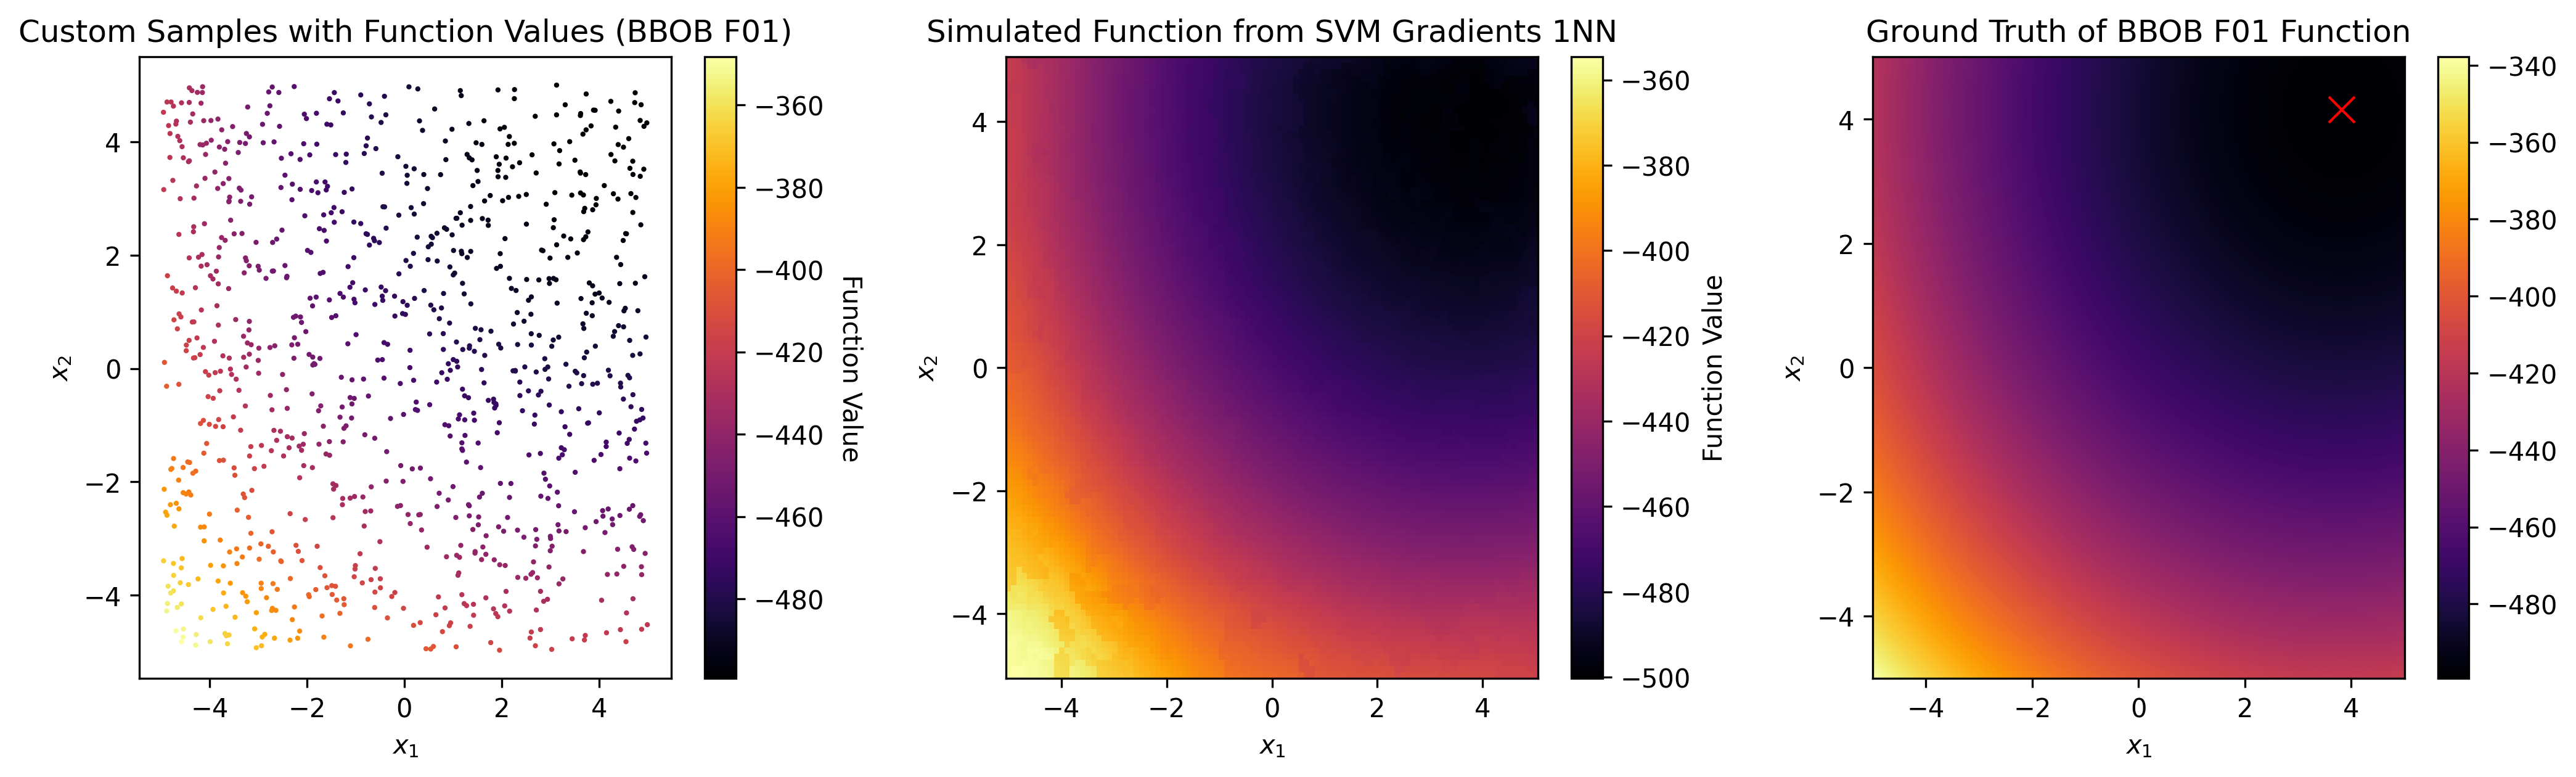

In [20]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "SVM Gradients 1NN", X1, X2, mesh_results_svm_grad_1nn)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

In [21]:
mesh_results_svm_grad_gpm = svm_grad_gpm(mesh_samples_tensor).reshape(X1.shape)

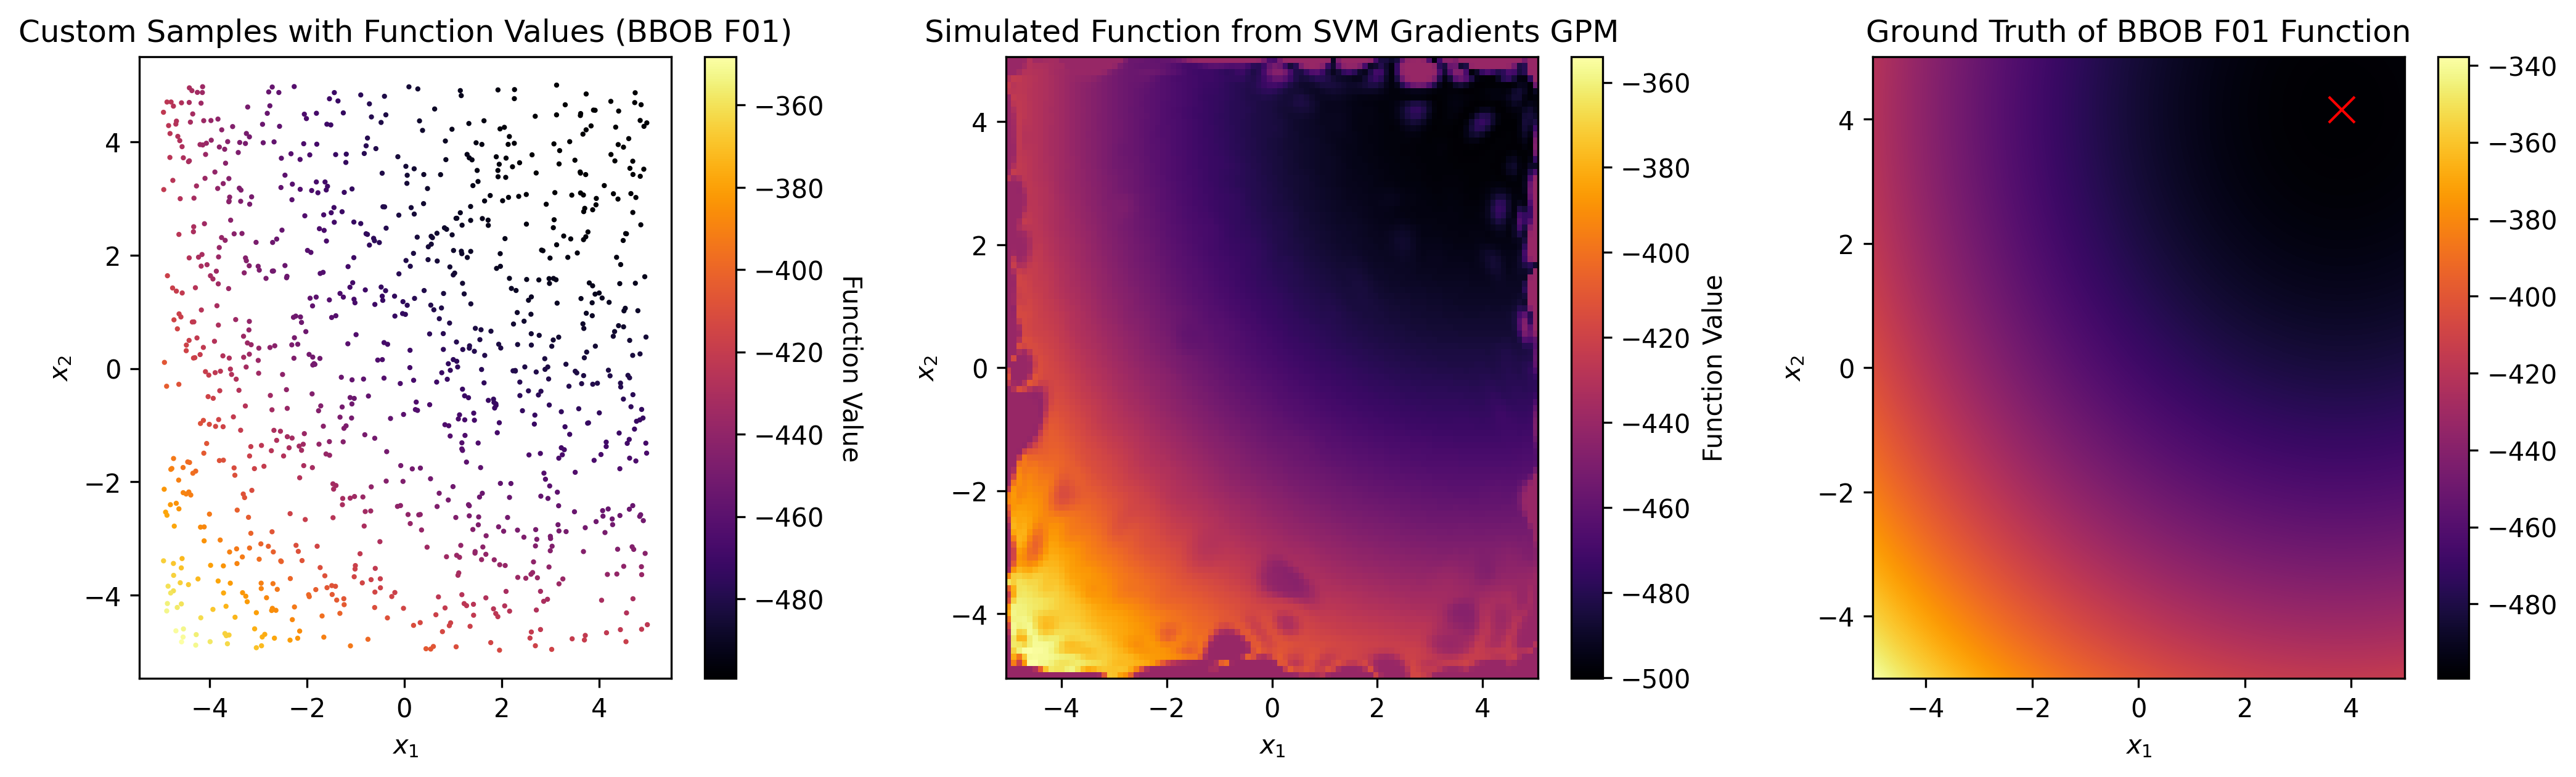

In [22]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "SVM Gradients GPM", X1, X2, mesh_results_svm_grad_gpm)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

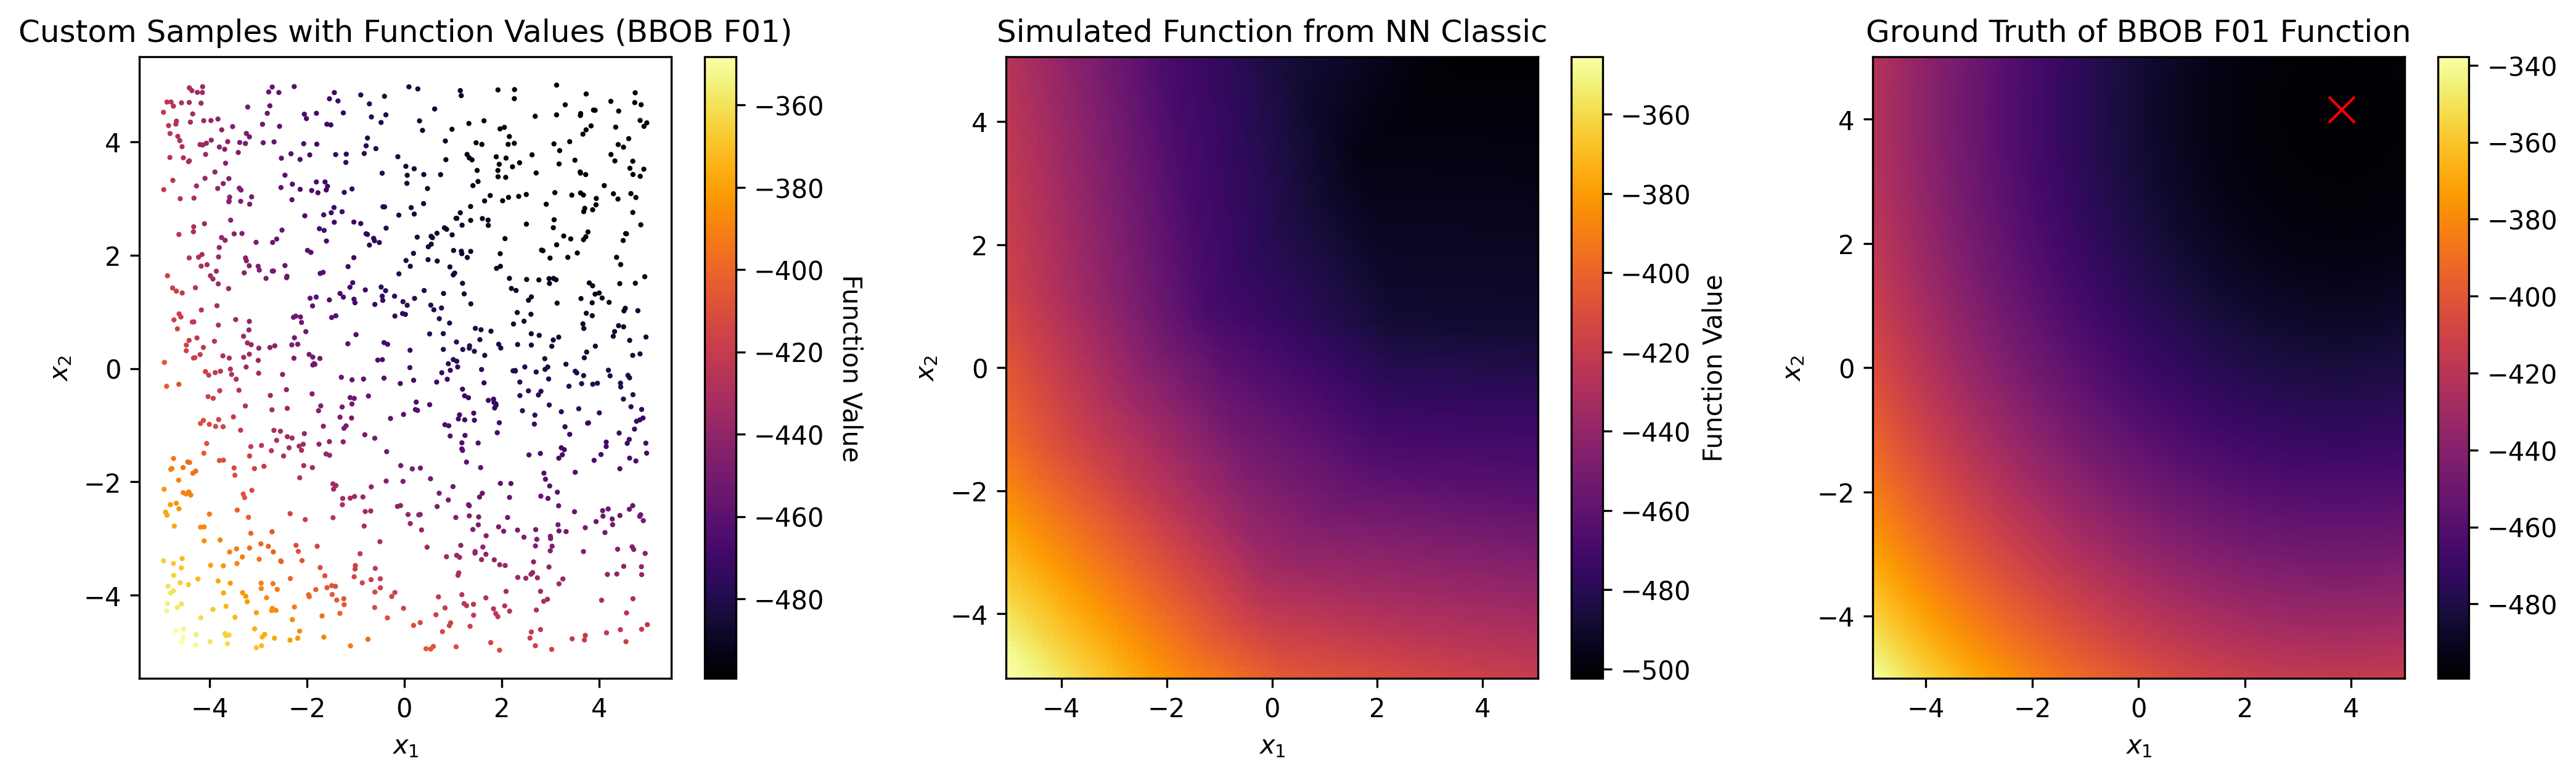

In [23]:
mesh_results_nn_mse = nn_classic(mesh_samples_tensor).detach().numpy().reshape(X1.shape)
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "NN Classic", X1, X2, mesh_results_nn_mse)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

##### NN with Taylor Loss

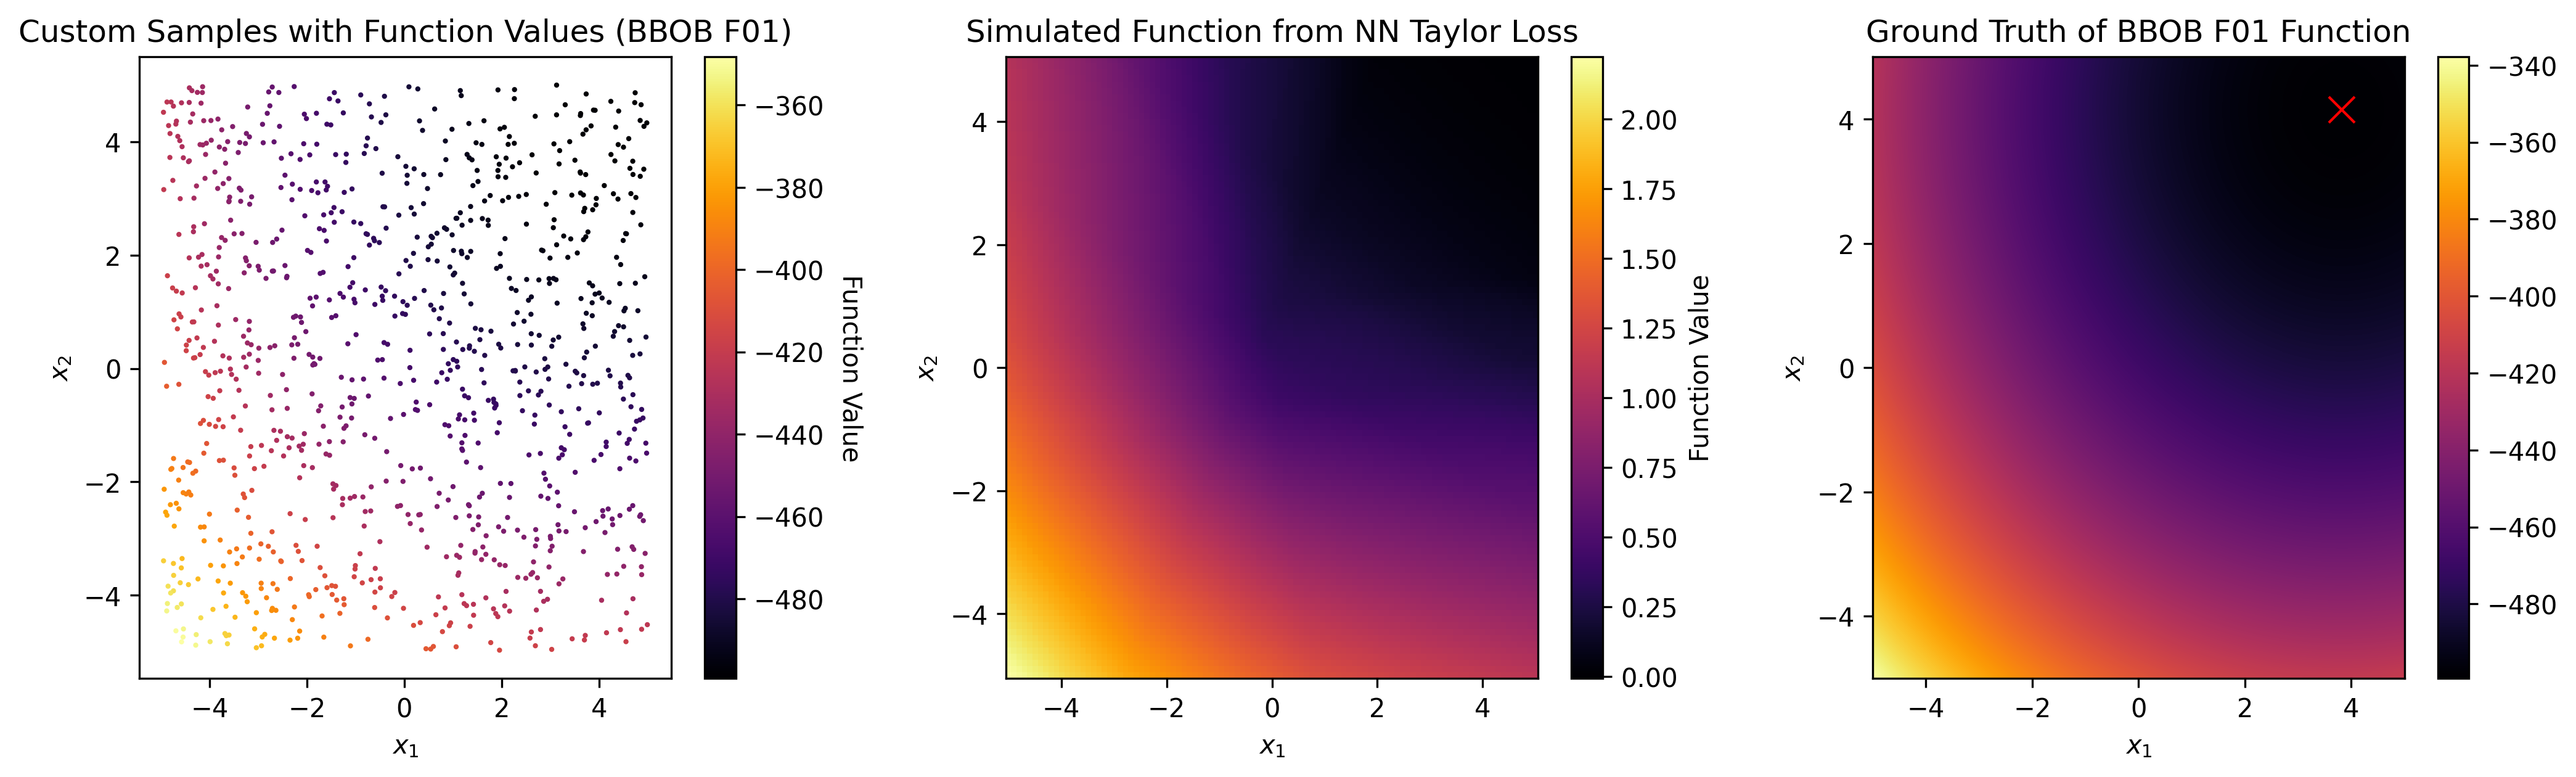

In [24]:
mesh_results_nn_taylor = (nn_taylor(mesh_samples_tensor).detach().numpy()).reshape(X1.shape)
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "NN Taylor Loss", X1, X2, mesh_results_nn_taylor)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

### Evaluation with optimizer

In [25]:
svm_classic_f = lambda x: svm_p1.predict(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_1nn_f = lambda x: svm_grad_1nn(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_gpm_f= lambda x: svm_grad_gpm(x.reshape(1, -1) if len(x.shape) == 1 else x)
nn_classic_f = lambda x: nn_classic(x.reshape(1, -1) if len(x.shape) == 1 else x).detach().numpy().flatten().astype(np.float64)
nn_taylor_f = lambda x: (nn_taylor(x.reshape(1, -1) if len(x.shape) == 1 else x)*70-500).detach().numpy().flatten().astype(np.float64)

functions = [
               [problem_f01, 'Groundtruth']
             , [svm_classic_f, 'SVM-Classic']
             , [svm_grads_1nn_f, 'SVM-Gradients-1NN']
             , [svm_grads_gpm_f, 'SVM-Gradients-GPM']
             , [nn_classic_f, 'NN-Classic']
             , [nn_taylor_f, 'NN-Taylor-Loss']
]

In [26]:
seed = 99
epsilon = 5e-4

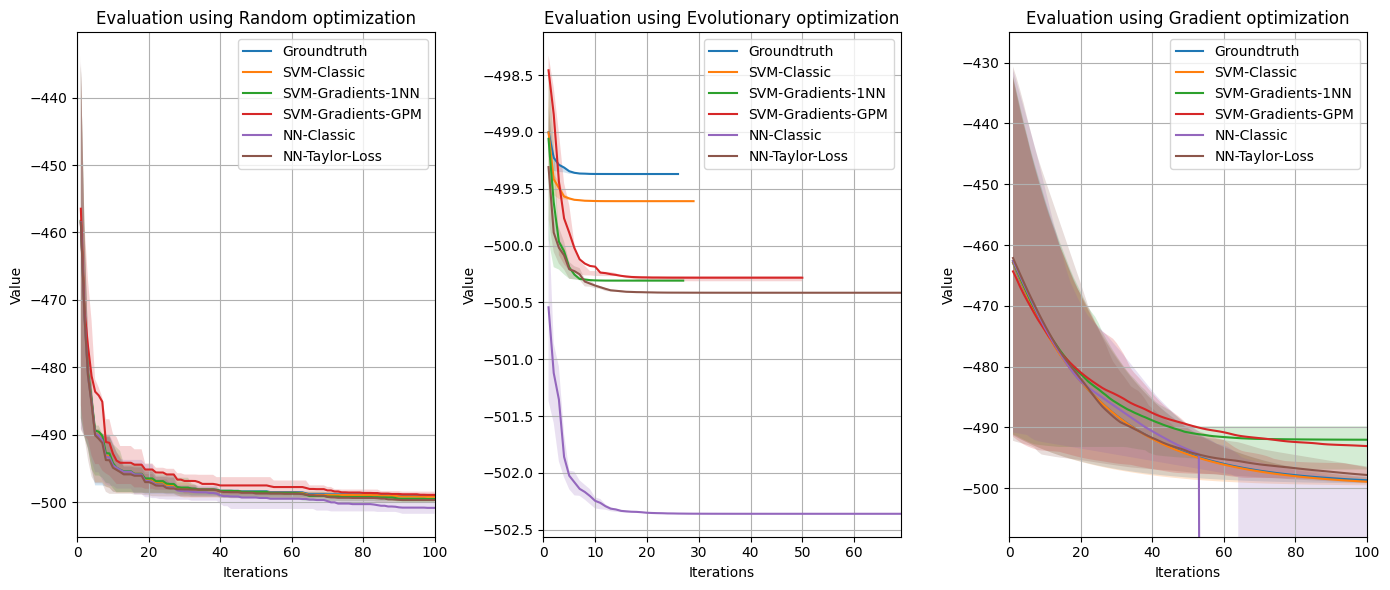

In [27]:
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 3, 1)
plot_optimization(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, seed=seed)
ax2 = plt.subplot(1, 3, 2)
plot_optimization(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, seed=seed)
plt.subplot(1, 3, 3)
plot_optimization(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, seed=seed, epsilon=epsilon)
plt.ylim(-508,-425)
plt.tight_layout()
plt.show()

C:\Users\schla\AppData\Local\Temp\ipykernel_27880\1382035152.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
C:\Users\schla\AppData\Local\Temp\ipykernel_27880\1382035152.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
C:\Users\schla\AppData\Local\Temp\ipykernel_27880\1382035152.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show 

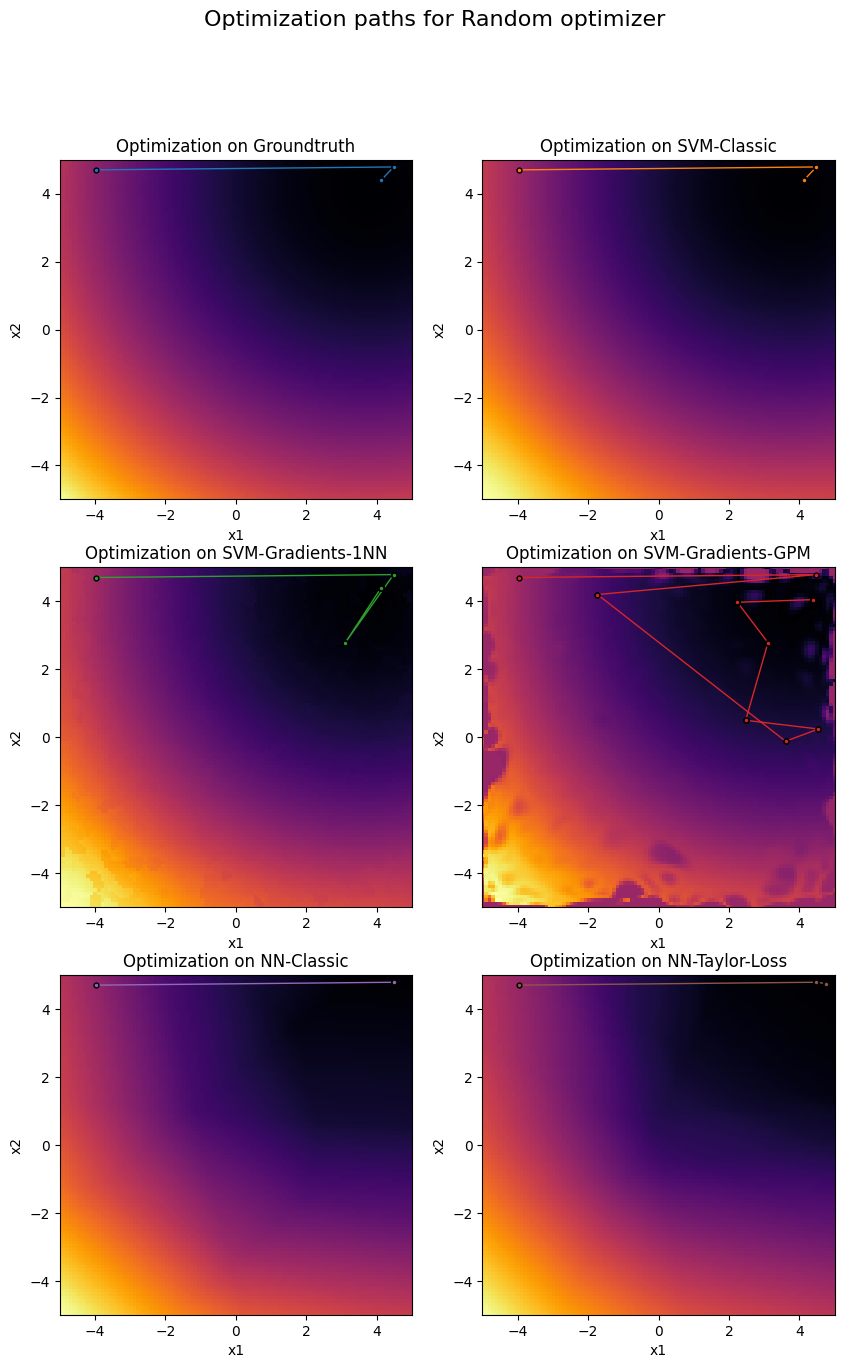

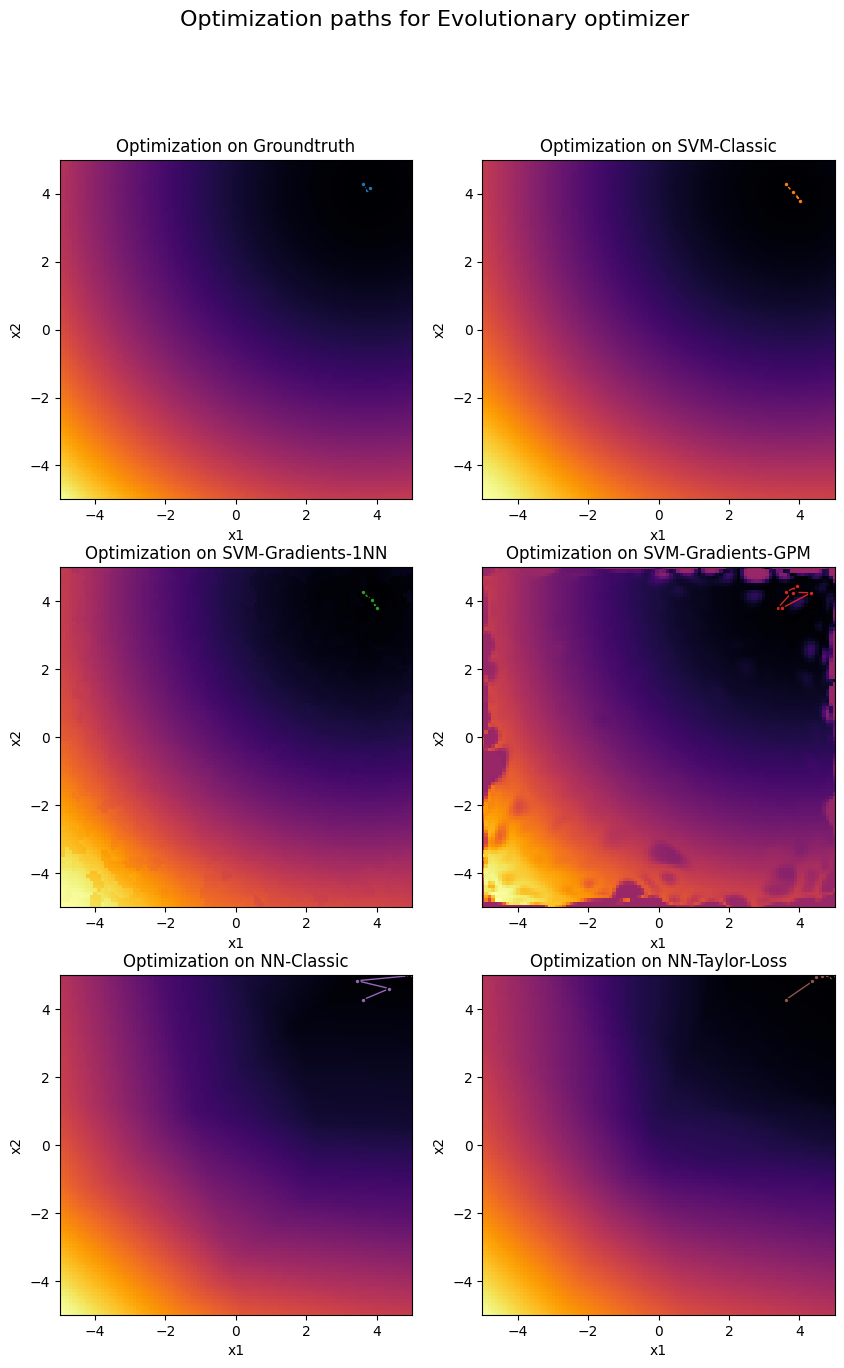

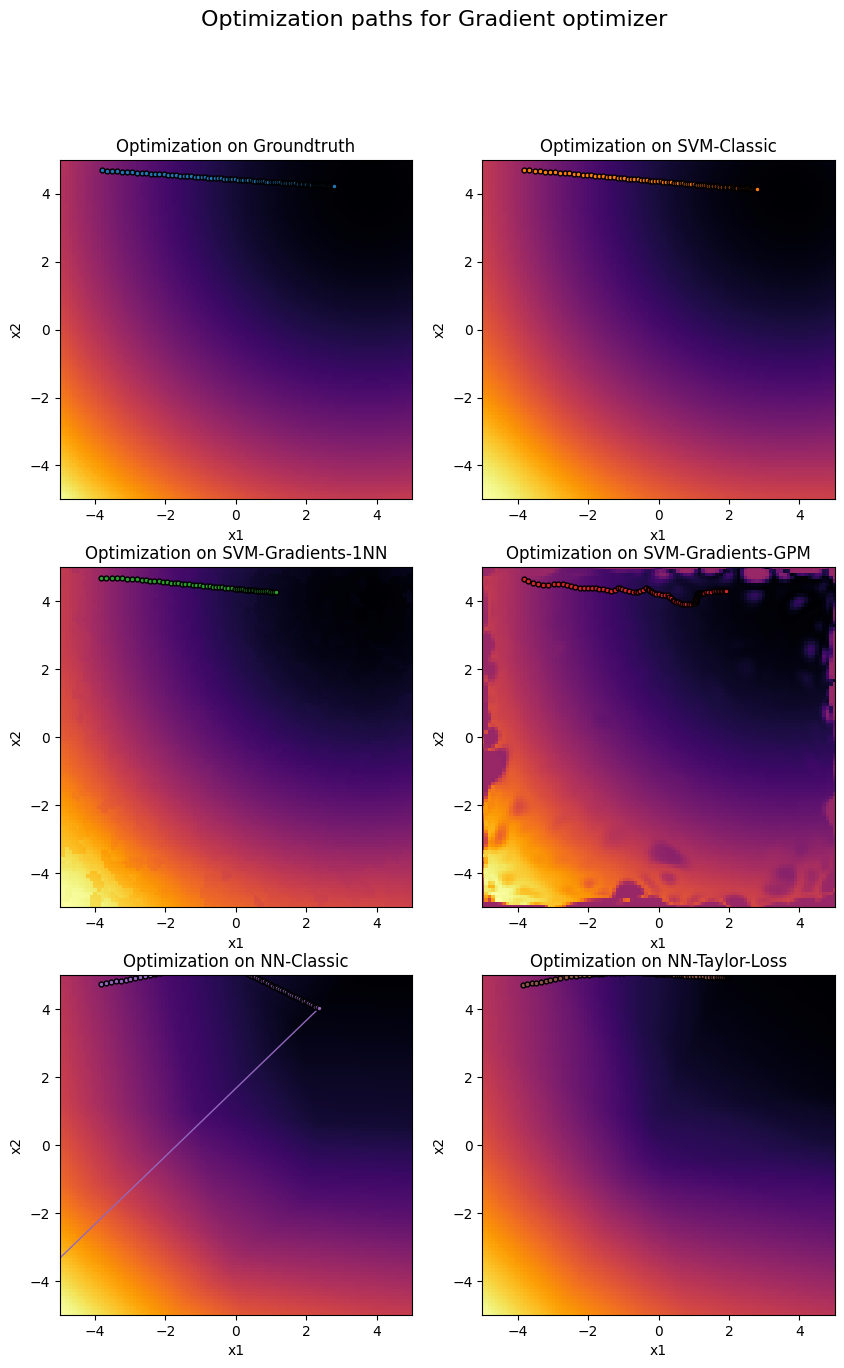

In [28]:
plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
plot_optimization_paths(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed, epsilon=epsilon).show()

### Evaluation with metrics

#### Correlation based

In [29]:
n_samples = 100
n_resampling = 10
df_corr_rho = pd.DataFrame(columns=[function[1] for function in functions])
df_corr_r = pd.DataFrame(columns=[function[1] for function in functions])

for i in range(n_resampling):
    X_test, y_test, _, _ = get_sample(problem_f01, n_samples=n_samples, n_dim=2, seed=i, method='random')
    row_r = []
    row_rho = []
    for function in functions:
        row_r.append(pearsonr(y_test, function[0](X_test))[0])
        row_rho.append(spearmanr(y_test, function[0](X_test))[0])
    df_corr_rho.loc[len(df_corr_rho)] = row_rho
    df_corr_r.loc[len(df_corr_r)] = row_r

c:\Users\schla\git\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\schla\git\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\schla\git\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

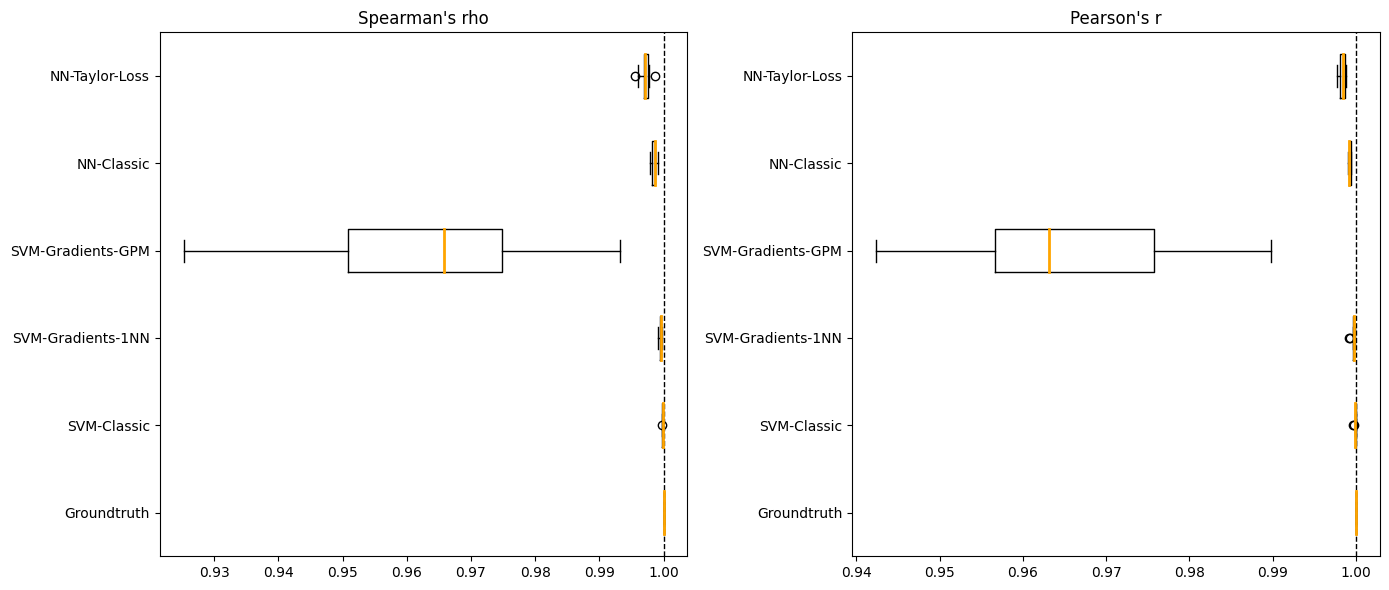

In [30]:
# boxplot of correlation coefficients
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Spearman's rho")
df_corr_rho.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.subplot(122)
plt.title("Pearson's r")
df_corr_r.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.tight_layout()
plt.show()

#### Optimizer-based
- number of iterations compared to on groundtruth
- coordinates of the found optimum compared to on the groundtruth
- y-value of the found optimum compared to on the groundtruth
- Correlation r between the evaluations of the optimizers compared to on groundtruth
- MSE between the evaluations of the optimizers compared to on groundtruth

each considering the mean values over x trials, for each optimizer

In [31]:
optims = ['Random', 'Evolutionary', 'Gradient']
n_trials = 30

In [32]:
df_nr_iter, df_optim_loc, df_optim_val, df_r, df_mse = calculate_eval_metrics(functions, optims, n_trials)

c:\ProgramData\Anaconda3\envs\python-3-10-env\MachineLearningProject\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Number of iterations

In [33]:
df_nr_iter

Groundtruth SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random         100.0±0.0   100.0±0.0         100.0±0.0         100.0±0.0   
Evolutionary  21.57±2.96  23.47±2.28        25.23±2.86        40.17±6.01   
Gradient       100.0±0.0   100.0±0.0       41.57±22.73       74.57±42.11   

              NN-Classic NN-Taylor-Loss  
Random         100.0±0.0      100.0±0.0  
Evolutionary  61.7±11.72      55.0±4.28  
Gradient      98.83±1.37      100.0±0.0

Optimum Location

In [34]:
df_optim_loc

Groundtruth              SVM-Classic  \
Random        [3.79 4.18]±[0.44 0.32]  [3.77 4.02]±[0.46 0.3 ]   
Evolutionary      [3.82 4.15]±[0. 0.]      [3.81 4.04]±[0. 0.]   
Gradient      [3.25 3.58]±[0.37 0.37]  [3.27 3.6 ]±[0.38 0.35]   

                    SVM-Gradients-1NN        SVM-Gradients-GPM  \
Random          [3.8 4.1]±[0.51 0.34]  [3.85 3.71]±[0.57 0.42]   
Evolutionary      [3.86 4.04]±[0. 0.]  [4.29 3.93]±[0.19 0.12]   
Gradient      [2.02 2.33]±[1.3  1.29]  [0.92 0.54]±[8.27 8.2 ]   

                                       NN-Classic           NN-Taylor-Loss  
Random                    [3.97 4.55]±[0.66 0.37]  [4.31 4.34]±[0.59 0.55]  
Evolutionary                      [5. 5.]±[0. 0.]          [5. 5.]±[0. 0.]  
Gradient      [-737.24 -733.83]±[1251.21 1248.57]  [2.93 3.69]±[1.27 0.85]

Optimum Value

In [35]:
df_optim_val

Groundtruth   SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random        -499.08±0.32  -499.18±0.43      -499.31±0.88      -498.82±0.62   
Evolutionary   -499.37±0.0   -499.61±0.0       -500.31±0.0      -500.27±0.02   
Gradient      -498.44±0.54  -498.64±0.62      -489.59±6.77     -486.04±21.41   

                    NN-Classic NN-Taylor-Loss  
Random            -500.58±1.23   -499.41±0.79  
Evolutionary       -502.36±0.0    -500.41±0.0  
Gradient      -1202.96±1260.01   -496.74±1.91

Correlation Score of Optimization Curves

In [36]:
df_r

Groundtruth SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random           1.0±0.0    1.0±0.01         0.99±0.01          0.96±0.1   
Evolutionary     1.0±0.0   0.92±0.07         0.92±0.09         0.79±0.16   
Gradient         1.0±0.0     1.0±0.0         0.92±0.11          0.8±0.36   

             NN-Classic NN-Taylor-Loss  
Random        0.98±0.04      0.99±0.02  
Evolutionary   0.87±0.1      0.88±0.09  
Gradient      0.85±0.19      0.98±0.01

MSE Score of Optimization Curves

In [37]:
df_mse

Groundtruth SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random           0.0±0.0   0.04±0.03         0.44±0.57          3.54±4.3   
Evolutionary     0.0±0.0    0.06±0.0         0.87±0.02         0.81±0.06   
Gradient         0.0±0.0   0.05±0.05      53.88±107.14      351.16±690.5   

                       NN-Classic NN-Taylor-Loss  
Random                  2.79±1.63      0.86±0.52  
Evolutionary            8.69±0.14      1.06±0.02  
Gradient      966071.01±2237144.0      9.76±8.41